# Sliding window approach for computation

In [ ]:
import re
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict
from utils.names import get_file_names, get_model_names

files = get_file_names()
models = get_model_names()

In [ ]:
WINDOW_SIZE = 60  # secondi
HOP_SIZE = 10     # secondi
MIN_REF_WORDS = 10  # soglia minima parole per calcolare il WER
OUTPUT_JSON = "raw_results/sliding_wer_results.json"

colors_models = {
    "whisper_large": "#55a868",
    "parakeet": "#4c72b0",
    "assemblyai": "#c44e52",
    "whisperx": "#f0e224"
}

## Computation

In [3]:
def convert_str_to_ms(time: str):
    # time format: HH:MM:SS,mmm
    h, m, s_ms = time.split(':')
    s, ms = s_ms.split(',')
    return (int(h)*3600 + int(m)*60 + int(s))*1000 + int(ms)

class Subtitle:
    def __init__(self, start_time: int, end_time: int, text: str):        
        self.start_time = start_time
        self.end_time = end_time
        self.text = text

def preprocess(srt_text):    
    pattern = re.compile(r'(\d+)\s+([\d:,]+) --> ([\d:,]+)\s+([\s\S]*?)(?=\n\d+\n|\Z)', re.MULTILINE)
    subtitles = []    
    for match in pattern.finditer(srt_text):
        start_time = convert_str_to_ms(match.group(2).strip())
        end_time = convert_str_to_ms(match.group(3).strip())
        text = match.group(4).strip().replace("\n"," ")
        if text:               
            subtitles.append(Subtitle(start_time, end_time, text))
                    
    return subtitles

In [4]:
from metrics_utils import normalize_text

def create_ref_word_timestamps(subtitles: List[Subtitle]) -> List[Dict]:
    """
    Distribuisce i token normalizzati della ref uniformemente nell'intervallo start-end.
    Restituisce lista di dict: {"start": float, "end": float, "word": str}
    """
    ref_words = []
    for sub in subtitles:
        tokens = normalize_text(sub.text).split()
        if not tokens:
            continue
        duration = (sub.end_time - sub.start_time) / 1000.0
        token_dur = duration / len(tokens)
        for i, token in enumerate(tokens):
            start_sec = (sub.start_time / 1000.0) + i * token_dur
            end_sec = start_sec + token_dur
            ref_words.append({"start": start_sec, "end": end_sec, "word": token})
    return ref_words

In [5]:
def extract_words_from_json(data_json):
    """
    Estrae parole e timestamp dai json ASR
    """
    hyp_words = []
    for seg in data_json:
        for w in seg["words"]:
            token = normalize_text(w["word"])
            if token.strip():
                hyp_words.append({"start": float(w["start"]), "end": float(w["end"]), "word": token})
    return hyp_words

In [9]:
def compute_wer(ref_tokens, hyp_tokens):
    r_len = len(ref_tokens)
    h_len = len(hyp_tokens)
    d = np.zeros((r_len + 1, h_len + 1), dtype=int)
    for i in range(r_len + 1):
        d[i][0] = i
    for j in range(h_len + 1):
        d[0][j] = j
    for i in range(1, r_len + 1):
        for j in range(1, h_len + 1):
            cost = 0 if ref_tokens[i - 1] == hyp_tokens[j - 1] else 1
            d[i][j] = min(
                d[i - 1][j] + 1,     # cancellazione
                d[i][j - 1] + 1,     # inserzione
                d[i - 1][j - 1] + cost  # sostituzione
            )
    S_D_I = d[r_len][h_len]
    return S_D_I, r_len


In [10]:
def sliding_window_analysis(ref_words, hyp_words, window_size, hop_size):
    """
    Calcola WER per finestre scorrevoli
    """
    max_time = max(ref_words[-1]["end"] if ref_words else 0, hyp_words[-1]["end"] if hyp_words else 0)
    windows = []
    t = 0.0
    while t < max_time:
        start = t
        end = t + window_size
        ref_segment = [w["word"] for w in ref_words if start <= w["start"] < end]
        hyp_segment = [w["word"] for w in hyp_words if start <= w["start"] < end]

        if len(ref_segment) == 0:
            windows.append({
                "start": start,
                "end": end,
                "WER": None,
                "valid": False,
                "ref_count": 0,
                "hyp_count": len(hyp_segment)
            })
        else:
            S_D_I, N = compute_wer(ref_segment, hyp_segment)
            windows.append({
                "start": start,
                "end": end,
                "WER": round(S_D_I / N, 3) if N > 0 else None,
                "valid": len(ref_segment) >= MIN_REF_WORDS,
                "ref_count": len(ref_segment),
                "hyp_count": len(hyp_segment)
            })
        t += hop_size
    return windows

In [11]:
def main(files, models):
    results = defaultdict(dict)

    for file in files:
        print(f"Processing {file}...")
        # Leggi SRT reference
        with open(f"../data/srt/ground-truth-cleaned/{file}.srt", "r", encoding="utf-8") as f:
            srt_content = f.read()
        subtitles = preprocess(srt_content)
        ref_words = create_ref_word_timestamps(subtitles)

        for model in models:
            with open(f"../data/{model}/json/{file}.json", "r", encoding="utf-8") as f:
                data_json = json.load(f)
            hyp_words = extract_words_from_json(data_json)
            results[file][model] = sliding_window_analysis(
                ref_words, hyp_words, WINDOW_SIZE, HOP_SIZE
            )

    with open(OUTPUT_JSON, "w", encoding="utf-8") as out:
        json.dump(results, out, indent=2, ensure_ascii=False)

    print(f"Analisi completata. Risultati salvati in {OUTPUT_JSON}")

In [ ]:
main(files,models)

## Plotting

In [2]:
def plot_episode(json_path, episode_name, selected_models):
    """
    Mostra il grafico WER per un episodio per i modelli selezionati
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    episode_data = data[episode_name]
    plt.figure(figsize=(12, 6))

    for model in selected_models:
        windows = episode_data[model]
        times = [w["start"] / 60 for w in windows]  # minuti
        wers = [w["WER"] if w["valid"] else np.nan for w in windows]
        plt.plot(times, wers, label=model, color=colors_models.get(model, "#000000"))

    # Ombreggiatura finestre senza ref
    valid_mask = [any(episode_data[m][i]["valid"] for m in selected_models) for i in range(len(next(iter(episode_data.values()))))]
    times = [w["start"] / 60 for w in next(iter(episode_data.values()))]
    for i, v in enumerate(valid_mask):
        if not v:
            plt.axvspan(times[i], times[i] + (WINDOW_SIZE / 60), color="gray", alpha=0.3)

    plt.xlabel("Tempo (minuti)")
    plt.ylabel("WER")
    plt.title(f"WER Sliding Window - {episode_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

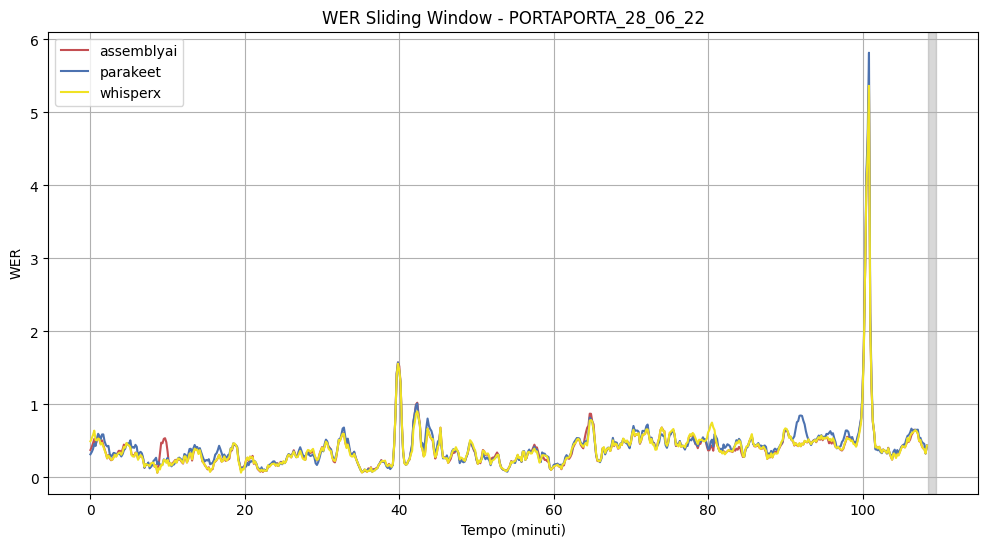

In [14]:
plot_episode(OUTPUT_JSON, "PORTAPORTA_28_06_22", ["assemblyai","parakeet","whisperx"])

#### Mezz'ora in più 10/10/21:
- Min 3-4 Clip di persona che parla in inglese: WhisperX traduce da inglese a italiano, ground-truth non include quella parte
- Min 7-8 Cambi repentini di discorso e dibattito: ASR fatica a elaborare 
#### Mezz'ora in più 14/03/21:
- Min 3-4 Clip clip in inglese: ground-truth non riporta, gli ASR traducono in italiano
- Min 22-23 clip in inglese: ground-truth non riporta, gli ASR traducono in italiano
#### Mezz'ora in più 24/10/21:
- Min 3-4 Clip clip in inglese: ground-truth non riporta, gli ASR traducono in italiano
#### PORTAPORTA_28_06_22:
- Lettura cartello minuto 100 e minuto 40
#### PRESADIRETTA_07_02_22:
- Minuto 45 e 50 sottotitoli non presenti di una intercettazione 
#### PRESADIRETTA_14_02_22
- Minuto 10 sottotitoli non presenti di una intercettazione 
- Minuto 61: taglio netto editing nella ground truth
#### PRESADIRETTA_14_03_22
- Minuto 10: clip in inglese
#### ULISSE 16_04_22:
- ASR trascrivono canto Brigata Sassari 
#### ULISSE_28_04_21:
- ASR trascrivono voci di sottofondo durante la sigla (minuto 4)
#### ULISSE_30_04_22:
- ASR trascrivono canzone minuto 10
- ASR trascrivono canzone minuto 84
#### ULISSE_23_04_22:
- ASR trascrivono canzone di Elton John (minuto 82)

**NOTA** : la trascrizione di canzoni è un misto tra italiano e testo originale